# Hamilton-Jacobi-Bellman equation

Consider the system \begin{array}{l}
dX_t = \sigma dW_t, ~~~ t \in [0,T],\\
X_0 = \xi,\\
dY_t = \Vert Z_t\Vert^2 dt + \sigma Z_t'dW_t, ~~~ t \in [0,T),\\
Y_T = g(X_T),
\end{array}
where $T=1$, $\sigma = \sqrt{2}$, $\xi = (0,0,\ldots,0)\in \mathbb{R}^{2}$, and $g(x) = \ln\left(0.5\left(1+\Vert x\Vert^2\right)\right)$.

The above equations are related to the Hamilton-Jacobi-Bellman equation
\begin{equation}
u_t = -\text{Tr}[D^2u] + \Vert Du\Vert^2,
\end{equation}
with terminal condition $u(T,x) = g(x)$. This equation admits the explicit solution
\begin{equation}
u(t,x) = -\ln\left(\mathbb{E}\left[\exp\left( -g(x + \sqrt{2} W_{T-t}) \right) \right] \right).
\end{equation}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time

In [ ]:
def phi_tf(t, X, Y, Z): # M x 1, M x D, M x 1, M x D
  return tf.reduce_sum(Z**2, 1, keepdims = True) # M x 1

def g_tf(X): # M x D
  return tf.math.log(0.5 + 0.5*tf.reduce_sum(X**2, 1, keepdims = True)) # M x 1

def mu_tf(t, X, Y, Z): # M x 1, M x D, M x 1, M x D
  return np.zeros([M,D]) # M x D

def sigma_tf(t, X, Y): # M x 1, M x D, M x 1
    return tf.sqrt(2.0)*tf.linalg.diag(X) # M x D x D

def net_u(model, t, X): # M x 1, M x D
  with tf.GradientTape() as tape:
    tape.watch(X)
    u = model(tf.concat([t,X], 1)) # M x 1
  Du = tape.gradient(u, X) # M x D
  return u, Du

def Dg_tf(X): # M x D
  with tf.GradientTape() as tape:
    tape.watch(X)
    g_tf_X = g_tf(X)
  return tape.gradient(g_tf_X, X) # M x D

def loss_function(model, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, 1 x D
  loss = 0
  X_list = []
  Y_list = []

  t0 = t[:,0,:]
  W0 = W[:,0,:]
  X0 = tf.tile(Xi,[M,1]) # M x D
  Y0, Z0 = net_u(model, t0,X0) # M x 1, M x D

  X_list.append(X0)
  Y_list.append(Y0)

  for n in range(0, N):
    t1 = t[:,n+1,:]
    W1 = W[:,n+1,:]
    X1 = X0 + mu_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.squeeze(tf.matmul(sigma_tf(t0,X0,Y0), tf.expand_dims(W1-W0,-1)), axis=[-1])
    Y1_tilde = Y0 + phi_tf(t0,X0,Y0,Z0)*(t1-t0)
    Y1_tilde += tf.reduce_sum(Z0*tf.squeeze(tf.matmul(sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1))), axis=1, keepdims = True)
    Y1, Z1 = net_u(model, t1, X1)

    loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

    t0 = t1
    W0 = W1
    X0 = X1
    Y0 = Y1
    Z0 = Z1

    X_list.append(X0)
    Y_list.append(Y0)

  loss += tf.reduce_sum(tf.square(Y1 - g_tf(X1)))
  loss += tf.reduce_sum(tf.square(Z1 - Dg_tf(X1)))

  X = tf.stack(X_list,axis=1)
  Y = tf.stack(Y_list,axis=1)

  return loss, X, Y, Y[0,0,0]

def fetch_minibatch():
  Dt = np.zeros((M,N+1,1), dtype=np.float32) # M x (N+1) x 1
  DW = np.zeros((M,N+1,D), dtype=np.float32) # M x (N+1) x D

  dt = T/N

  Dt[:,1:,:] = dt
  DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D)).astype(np.float32)

  t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
  W = np.cumsum(DW,axis=1) # M x (N+1) x D

  return t, W

def train(model, N_Iter, learning_rate):
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  start_time = time.time()
  for it in range(N_Iter):

    t_batch, W_batch = fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D

    with tf.GradientTape() as tape:
      loss, _, _, _ = loss_function(model, t_batch, W_batch, Xi)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Print
    if it % 100 == 0:
      elapsed = time.time() - start_time
      print('It: %d, Loss: %.3e, Time: %.2f, Learning Rate: %.3e' % (it, loss, elapsed, learning_rate))
      start_time = time.time()


def predict(model, Xi_star, t_star, W_star):
  _, X_star, Y_star, _ = loss_function(model, t_star, W_star, Xi_star)
  return X_star, Y_star

In [ ]:
M = 100 # number of trajectories (batch size)
N = 50 # number of time snapshots
D = 2 # number of dimensions

Xi = np.zeros([1,D]).astype(np.float32)
T = 1.0

def build_model(num_layers=4, size_layer=128):
  model = keras.models.Sequential()
  model.add(keras.Input(D+1))

  for _ in range(num_layers):
    model.add(keras.layers.Dense(size_layer, activation=tf.math.sin, kernel_initializer='glorot_uniform'))

  model.add(keras.layers.Dense(1))
  return model

model = build_model()

train(model, N_Iter = 500, learning_rate=1e-3)
train(model, N_Iter = 500, learning_rate=1e-4)
# train(model, N_Iter = 500, learning_rate=1e-5)
# train(model, N_Iter = 500, learning_rate=1e-6)

It: 0, Loss: 7.561e+01, Time: 1.76, Learning Rate: 1.000e-03
It: 100, Loss: 3.415e-01, Time: 88.77, Learning Rate: 1.000e-03
It: 200, Loss: 1.834e-02, Time: 88.30, Learning Rate: 1.000e-03
It: 300, Loss: 6.318e-05, Time: 88.76, Learning Rate: 1.000e-03
It: 400, Loss: 7.591e-03, Time: 88.90, Learning Rate: 1.000e-03
It: 0, Loss: 9.629e-05, Time: 2.05, Learning Rate: 1.000e-04
It: 100, Loss: 6.301e-05, Time: 89.47, Learning Rate: 1.000e-04
It: 200, Loss: 5.949e-05, Time: 94.39, Learning Rate: 1.000e-04
It: 300, Loss: 5.873e-05, Time: 91.45, Learning Rate: 1.000e-04
It: 400, Loss: 5.785e-05, Time: 92.03, Learning Rate: 1.000e-04
It: 500, Loss: 5.684e-05, Time: 89.87, Learning Rate: 1.000e-04
It: 600, Loss: 5.575e-05, Time: 90.71, Learning Rate: 1.000e-04
It: 700, Loss: 5.457e-05, Time: 90.74, Learning Rate: 1.000e-04
It: 800, Loss: 5.339e-05, Time: 89.98, Learning Rate: 1.000e-04
It: 900, Loss: 5.219e-05, Time: 90.47, Learning Rate: 1.000e-04


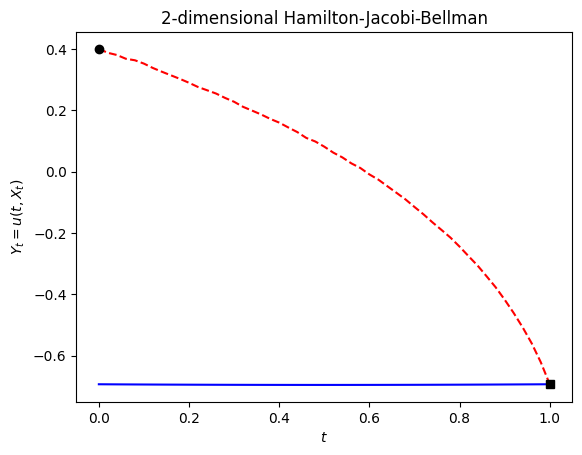

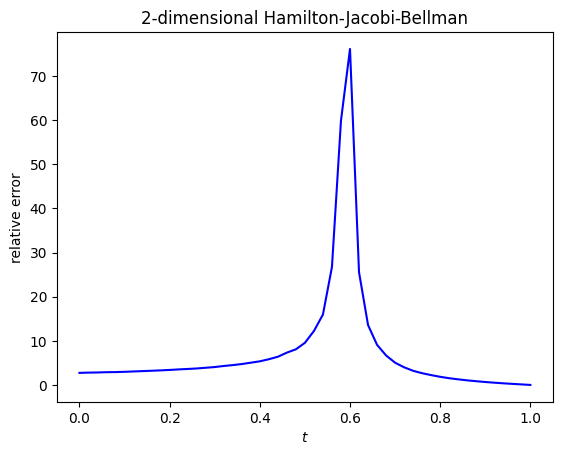

In [ ]:
def predict(model, Xi_star, t_star, W_star):
  _, X_star, Y_star, _ = loss_function(model, t_star, W_star, Xi_star)
  return X_star, Y_star

t_test, W_test = fetch_minibatch()

X_pred, Y_pred = predict(model, Xi, t_test, W_test)

def g(X): # MC x NC x D
    return np.log(0.5 + 0.5*np.sum(X**2, axis=2, keepdims=True)) # MC x N x 1

def u_exact(t, X): # NC x 1, NC x D
    MC = 10**5
    NC = t.shape[0]

    W = np.random.normal(size=(MC,NC,D)) # MC x NC x D

    return -np.log(np.mean(np.exp(-g(X + np.sqrt(2.0*np.abs(T-t))*W)),axis=0))

Y_test = u_exact(t_test[0,:,:], X_pred[0,:,:])

Y_test_terminal = np.log(0.5 + 0.5*np.sum(X_pred[:,-1,:]**2, axis=1, keepdims=True))

plt.figure()
plt.plot(t_test[0:1,:,0][0],Y_pred[0:1,:,0].numpy()[0],'b',label='Learned $u(t,X_t)$')
#plt.plot(t_test[1:5,:,0].T,Y_pred[1:5,:,0].T,'b')
plt.plot(t_test[0,:,0].T,Y_test[:,0].T,'r--',label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1,-1,0],Y_test_terminal[0:1,0],'ks',label='$Y_T = u(T,X_T)$')
#plt.plot(t_test[1:5,-1,0],Y_test_terminal[1:5,0])
plt.plot([0],Y_test[0,0],'ko',label='$Y_0 = u(0,X_0)$')
plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('{}-dimensional Hamilton-Jacobi-Bellman'.format(D))
plt.show()

errors = np.sqrt((Y_test-Y_pred[0,:,:])**2/Y_test**2)

plt.figure()
plt.plot(t_test[0,:,0],errors,'b')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title('{}-dimensional Hamilton-Jacobi-Bellman'.format(D))
plt.show()